In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd # to play audio in the notebook
import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [3]:
#load and sort data
RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
dir_list = os.listdir(RAV)
dir_list.sort()
dir_list

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [4]:
#creating the meta-data of RAVDESS dataset
emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.head()


,labels,source,path
0,male_calm,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
1,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
2,male_sad,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
3,male_calm,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
4,male_calm,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...


In [5]:
# RAV_df['path'][0]
RAV_df.loc[RAV_df['path'] == '/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-02-02-02-01-20.wav']


,labels,source,path
1191,female_calm,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...


In [6]:
RAV_df.labels.value_counts()

male_calm          96
male_sad           96
male_fear          96
male_happy         96
male_disgust       96
male_angry         96
male_surprise      96
female_surprise    96
female_disgust     96
female_fear        96
female_sad         96
female_calm        96
female_happy       96
female_angry       96
male_neutral       48
female_neutral     48
Name: labels, dtype: int64

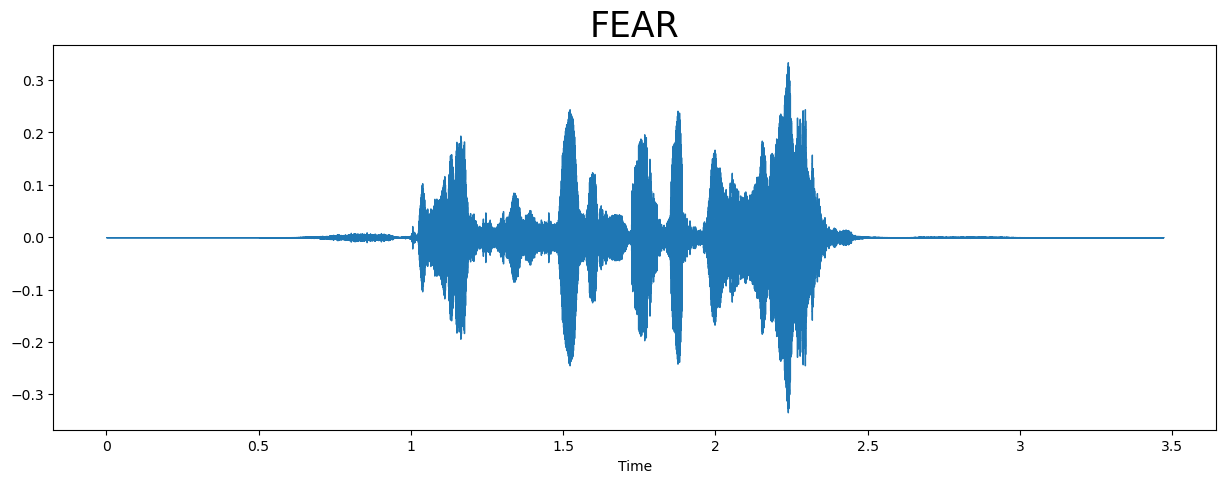

In [7]:
# Explore the data
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'
data, sample_rate = librosa.load(fname)
plt.figure(figsize = (15, 5))
librosa.display.waveshow(data, sr = sample_rate)
plt.title('FEAR', size = 25)

# Audio
ipd.Audio(fname)

male_calm          96
male_sad           96
male_fear          96
male_happy         96
male_disgust       96
male_angry         96
male_surprise      96
female_surprise    96
female_disgust     96
female_fear        96
female_sad         96
female_calm        96
female_happy       96
female_angry       96
male_neutral       48
female_neutral     48
Name: labels, dtype: int64


(1440, 3)

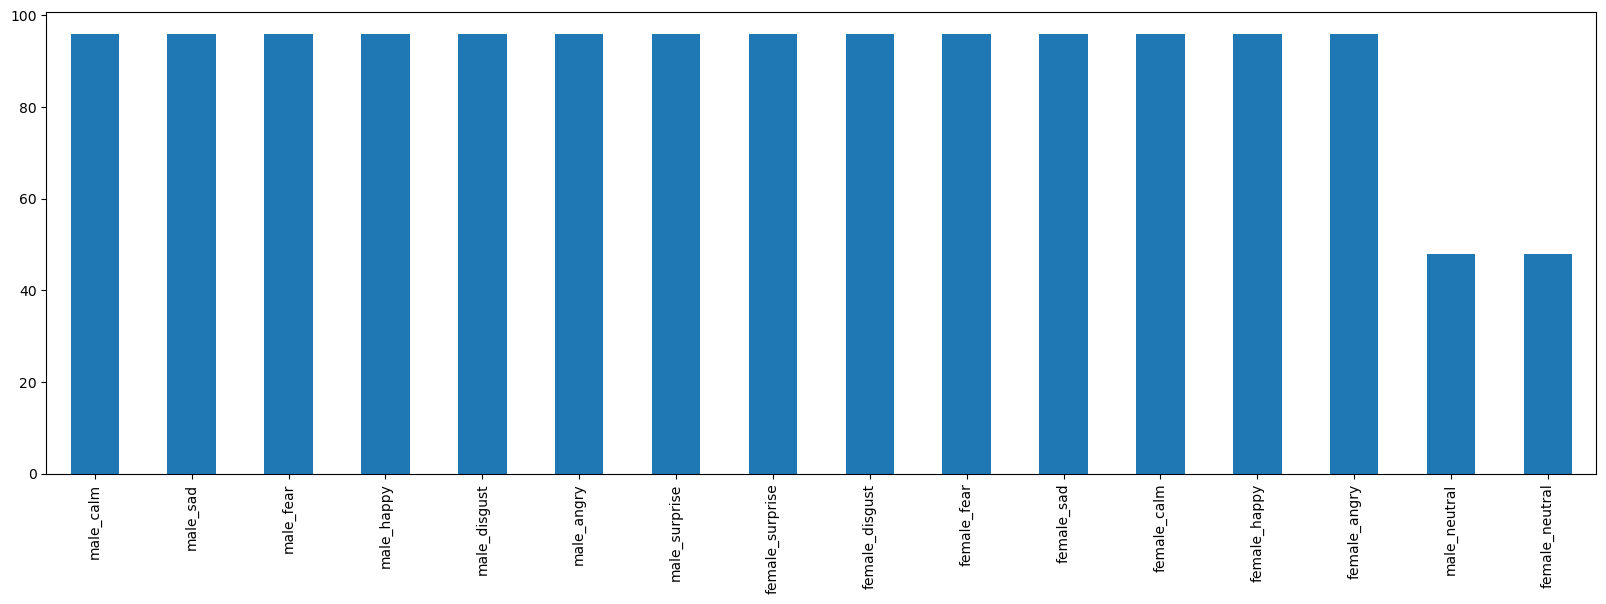

In [8]:
df = RAV_df
plt.figure(figsize = (20, 6))
df.labels.value_counts().plot(kind = 'bar')
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)
df.shape

In [9]:
df.shape


(1440, 3)

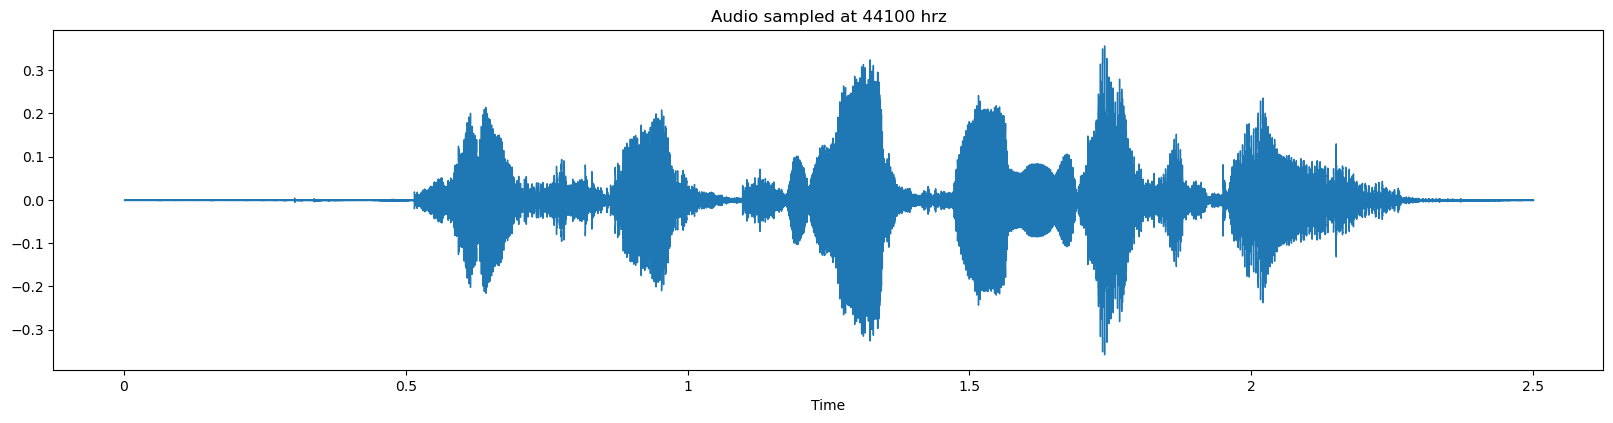

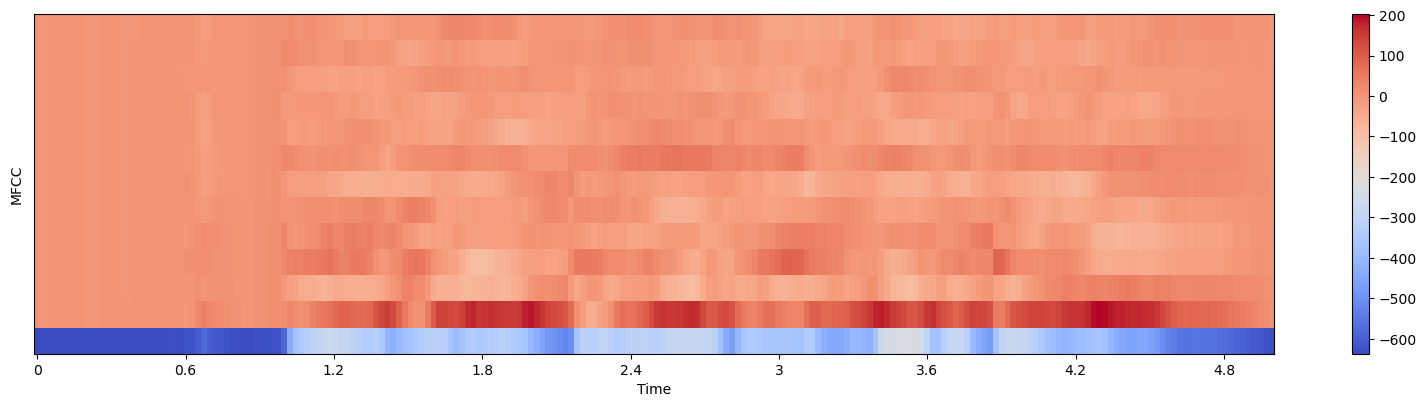

In [10]:
# visualise the MFCC
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
# X, sample_rate = librosa.load(path,res_type='kaiser_fast', duration=2.5,sr=22050*2,offset=0.5)  
X, sample_rate = librosa.load(path, duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

216
216


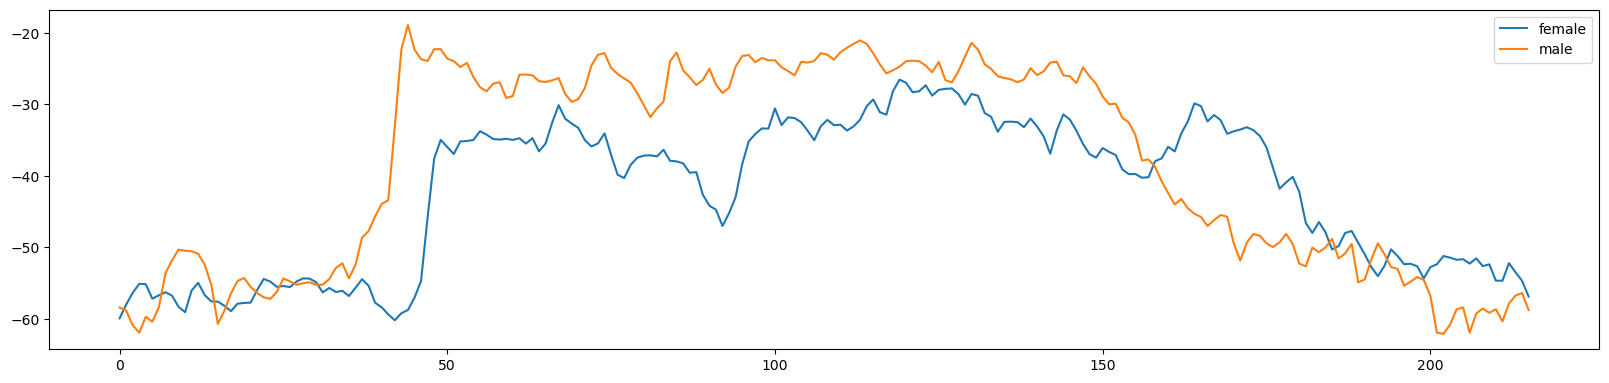

In [11]:
# find the male and female feature difference.
# Source - RAVDESS; Gender - Female; Emotion - happy 
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - happy 
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

In [12]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")


In [13]:
# Extracting the MFCC feature as an image (Matrix format). 
def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X



In [14]:
# Create the 2D CNN model 

def get_2d_conv_model(n):
    nclass = 16
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


In [15]:
ref = pd.read_csv("/kaggle/working/Data_path.csv")
ref.head()
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(ref, n = n_mfcc, aug = 0, mfcc = 1)

100%|██████████| 1440/1440 [01:09<00:00, 20.58it/s]


In [16]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc, ref.labels, test_size=0.25, shuffle=True, random_state=42)
                              
# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=50)

Epoch 1/50


2023-04-03 10:31:36.641011: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/68 - 13s - loss: 2.7573 - acc: 0.1333 - val_loss: 2.4280 - val_acc: 0.2056 - 13s/epoch - 193ms/step
Epoch 2/50
68/68 - 1s - loss: 2.3984 - acc: 0.2065 - val_loss: 2.5430 - val_acc: 0.1222 - 811ms/epoch - 12ms/step
Epoch 3/50
68/68 - 1s - loss: 2.2357 - acc: 0.2435 - val_loss: 2.7459 - val_acc: 0.1111 - 911ms/epoch - 13ms/step
Epoch 4/50
68/68 - 1s - loss: 2.1159 - acc: 0.2833 - val_loss: 2.5801 - val_acc: 0.1417 - 733ms/epoch - 11ms/step
Epoch 5/50
68/68 - 1s - loss: 1.9715 - acc: 0.3333 - val_loss: 2.4284 - val_acc: 0.1694 - 714ms/epoch - 11ms/step
Epoch 6/50
68/68 - 1s - loss: 1.8543 - acc: 0.3509 - val_loss: 2.5797 - val_acc: 0.1667 - 703ms/epoch - 10ms/step
Epoch 7/50
68/68 - 1s - loss: 1.6821 - acc: 0.4259 - val_loss: 1.7886 - val_acc: 0.3556 - 827ms/epoch - 12ms/step
Epoch 8/50
68/68 - 1s - loss: 1.5758 - acc: 0.4491 - val_loss: 1.8380 - val_acc: 0.3556 - 773ms/epoch - 11ms/step
Epoch 9/50
68/68 - 1s - loss: 1.4472 - acc: 0.4889 - val_loss: 1.4393 - val_acc: 0.4917 - 774ms/epo

In [17]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def _save_model_(filename):
    """
    saves the trained model in .h format as well save its json version
    """
    # Save model and weights
    model_name = filename + '.h5'  #'Emotion_Model_aug.h5'
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Save model and weights at %s ' % model_path)

    # Save the model to disk
    model_json = model.to_json()
    with open(filename + ".json", "w") as json_file:
        json_file.write(model_json)
    print("file saved to system")


class get_results:
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)
    
    def accuracy_results_gender(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''
    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
        
        actual = pd.DataFrame(actual).replace({'female_angry':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happy':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'female_calm':'female'
                   , 'male_angry':'male'
                   , 'male_fear':'male'
                   , 'male_happy':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                   , 'male_calm':'male'
                  })
        preds = pd.DataFrame(preds).replace({'female_angry':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happy':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'female_calm':'female'
                   , 'male_angry':'male'
                   , 'male_fear':'male'
                   , 'male_happy':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                   , 'male_calm':'male'
              })

        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)

In [18]:
_save_model_('mfcc_model')

Save model and weights at /kaggle/working/saved_models/mfcc_model.h5 
file saved to system


In [19]:
ref.labels.unique()

array(['male_calm', 'male_neutral', 'male_sad', 'male_fear', 'male_happy',
       'male_disgust', 'male_angry', 'male_surprise', 'female_surprise',
       'female_neutral', 'female_disgust', 'female_fear', 'female_sad',
       'female_calm', 'female_happy', 'female_angry'], dtype=object)

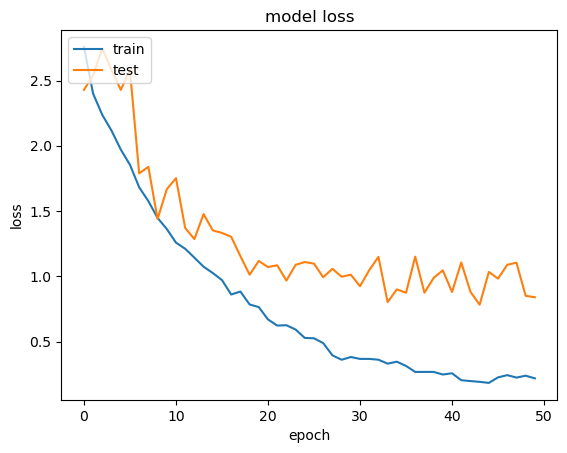

accuracy: 72.78%
23/23 - 0s - 245ms/epoch - 11ms/step


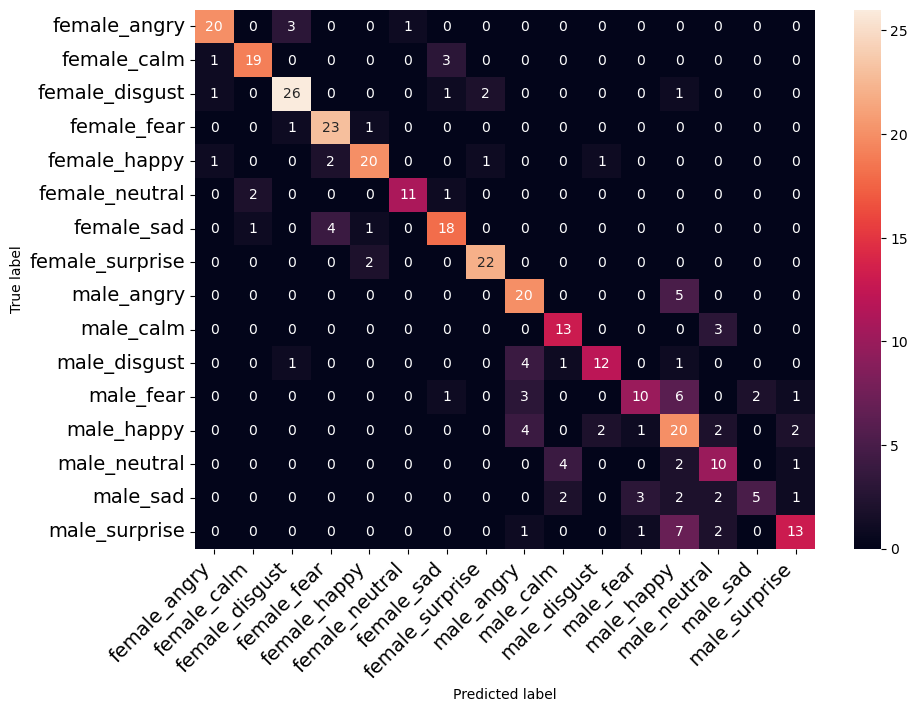

In [20]:
#plot and confusion matrix
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)


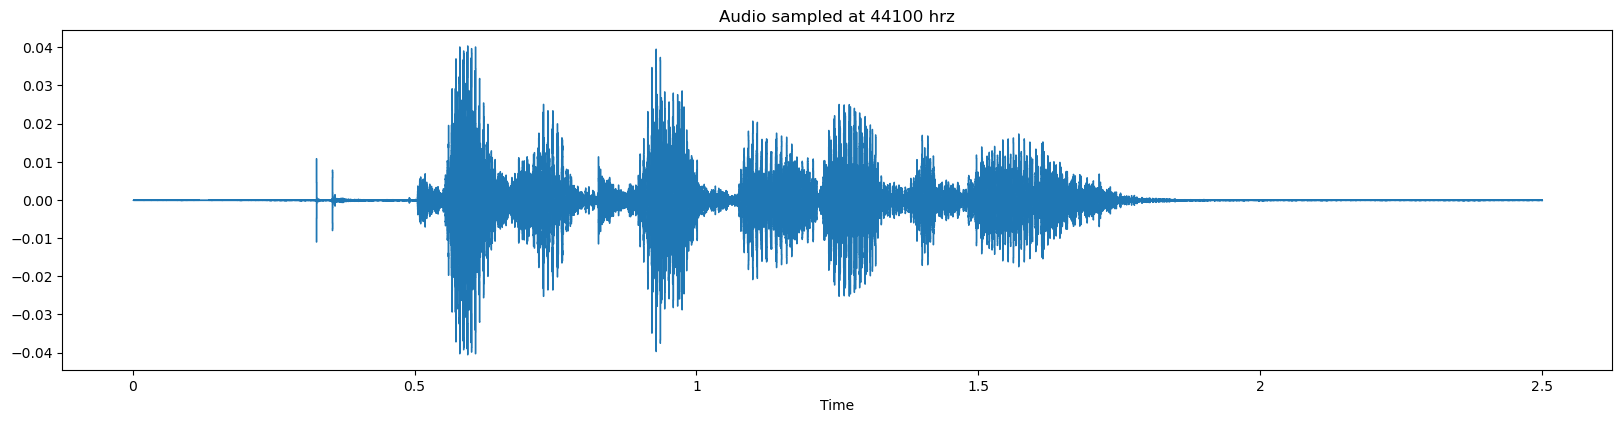

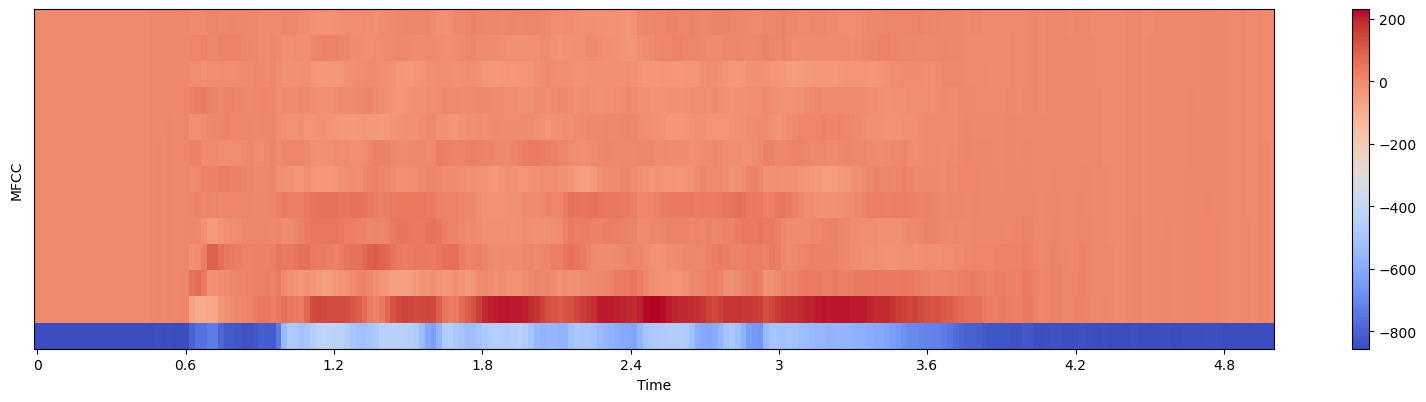

In [21]:
path = '/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav'
X, sample_rate = librosa.load(path, duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

In [23]:
model_name = 'mfcc_model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_aug.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/mfcc_model.h5 


In [24]:
# model vaalidation
# loading json and model architecture 
json_file = open('mfcc_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/mfcc_model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 72.78%


In [25]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

23/23 [==============================] - 0s 4ms/step


array([11, 15,  6,  3, 11,  8,  5,  1,  2,  9,  7,  0,  8,  3,  8,  2,  1,
       12,  3,  6,  3,  3,  2, 13,  0, 12, 10, 14, 12, 15, 12, 10, 12,  8,
        8,  8, 13,  8,  3,  2,  3,  6,  2, 15, 12, 10,  5, 12,  0,  7, 12,
        4, 13,  1,  4,  2,  4,  1, 12, 12, 11,  2, 12,  3,  3,  3,  1, 10,
        6, 10,  3,  4,  7,  3, 12, 12, 10,  0, 10,  0, 12,  6, 12,  8,  1,
       12,  4,  2,  8,  0,  3,  0,  2,  0,  2, 12,  9,  8,  5,  8,  6,  8,
        8,  9, 11,  6,  7,  7,  8, 12,  0,  1,  1,  9,  7,  4, 13, 12, 11,
        8,  0,  6,  0, 15,  8,  8,  3,  9,  6,  2,  9, 15,  9,  9,  3, 11,
        6, 10,  2,  2,  8,  4,  2, 11, 13, 13, 12,  8, 14,  1, 13,  3,  2,
        9,  0, 12,  7,  9, 15,  7, 13,  8,  5,  2,  2,  2, 11,  0,  1,  1,
        7, 12,  4,  4, 12,  0, 12, 12, 10,  6,  5,  2,  2,  6,  1, 14,  4,
        1,  3, 12,  9,  1,  6,  7, 10,  1, 12,  4,  6,  0,  4, 13, 11,  7,
        8,  7,  9,  3,  9, 15,  7,  9,  2,  6,  6,  9,  4,  4,  5, 15,  4,
       13,  7,  7, 14,  3

In [26]:
# appending the labels
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,female_surprise,female_surprise
171,male_happy,male_happy
172,female_happy,female_happy
173,female_fear,female_happy
174,male_surprise,male_happy
175,female_angry,female_angry
176,male_happy,male_happy
177,male_angry,male_happy
178,male_disgust,male_disgust
179,female_sad,female_sad


In [27]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,23
female_calm,22
female_disgust,31
female_fear,29
female_happy,24
female_neutral,12
female_sad,24
female_surprise,25
male_angry,32


0.7305555555555555


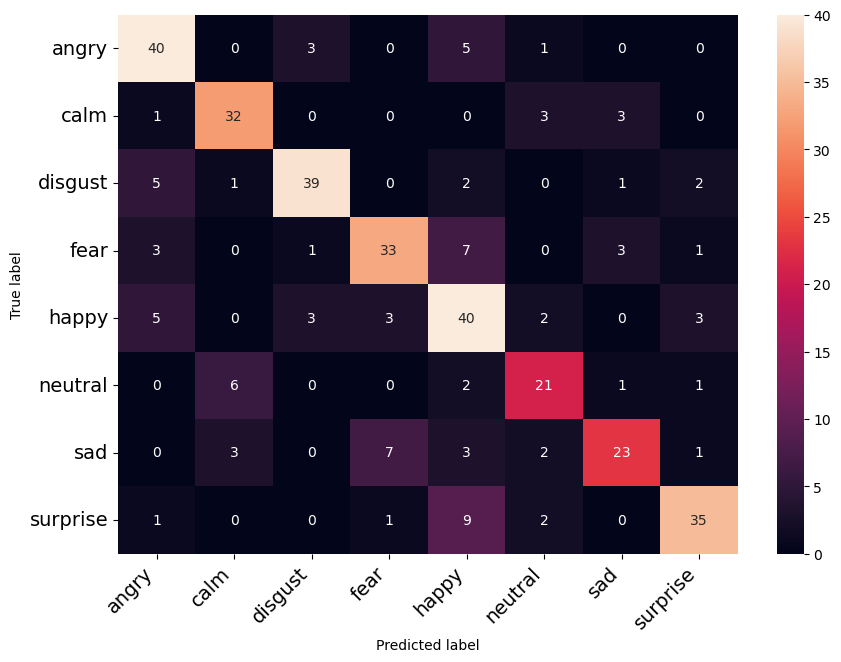

In [28]:
# emotion classification accuracy
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_calm':'calm'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_calm':'calm'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_calm':'calm'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_calm':'calm'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)


In [29]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()  
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.73      0.82      0.77        49
        calm       0.76      0.82      0.79        39
     disgust       0.85      0.78      0.81        50
        fear       0.75      0.69      0.72        48
       happy       0.59      0.71      0.65        56
     neutral       0.68      0.68      0.68        31
         sad       0.74      0.59      0.66        39
    surprise       0.81      0.73      0.77        48

    accuracy                           0.73       360
   macro avg       0.74      0.73      0.73       360
weighted avg       0.74      0.73      0.73       360



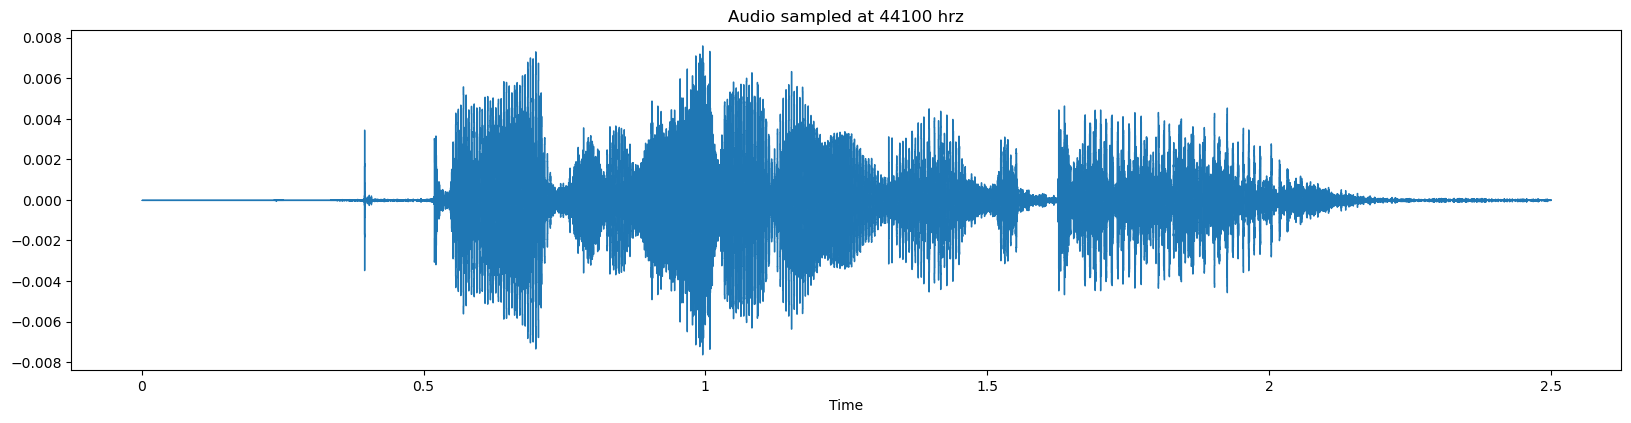

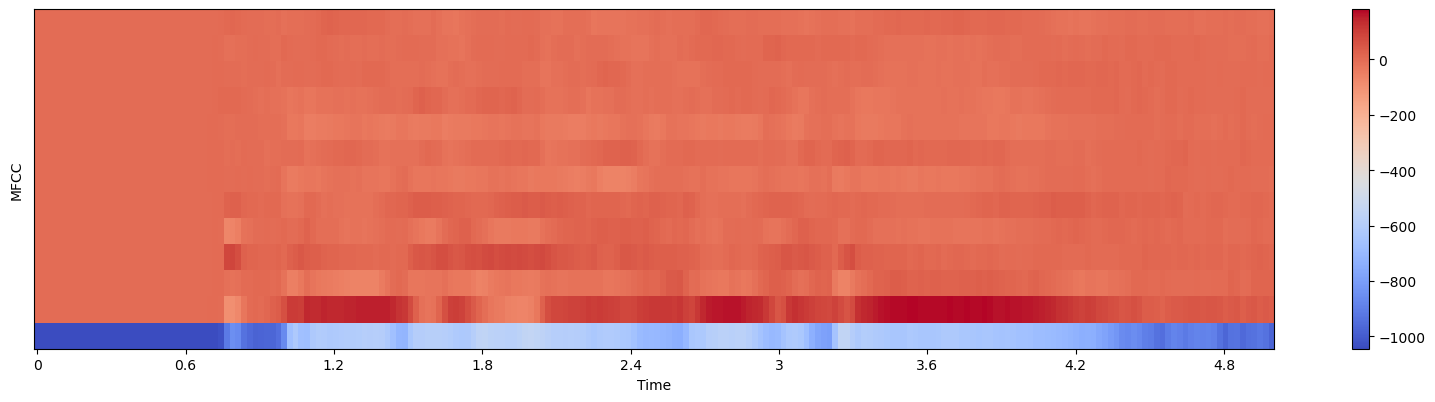

In [33]:
# Extracting the MFCC feature as an image (Matrix format). 
def prepare_data1(fname, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
#     for fname in tqdm(df.path):
    file_path = fname
    data, _ = librosa.load(file_path, sr=sampling_rate
                           ,duration=2.5
                           ,offset=0.5
                          )

    # Random offset / Padding
    if len(data) > input_length:
        max_offset = len(data) - input_length
        offset = np.random.randint(max_offset)
        data = data[offset:(input_length+offset)]
    else:
        if input_length > len(data):
            max_offset = input_length - len(data)
            offset = np.random.randint(max_offset)
        else:
            offset = 0
        data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

    if mfcc == 1:
        # MFCC extraction 
        MFCC = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=n_mfcc)
        MFCC = np.expand_dims(MFCC, axis=-1)
        X[cnt] = MFCC


    cnt += 1
    
    return X

path = '/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-02-02-02-01-20.wav'
X, sample_rate = librosa.load(path, duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data1(path, n = n_mfcc, aug = 0, mfcc = 1)



In [39]:
preds = loaded_model.predict(mfcc, 
                         batch_size=16, 
                         verbose=2)
x_labels=['female_angry','female_calm', 'female_disgust', 'female_fear', 'female_happy', 'female_neutral', 'female_sad', 'female_surprise', 'male_angry', 'male_calm', 'male_disgust', 'male_fear', 'male_happy', 'male_neutral', 'male_sad', 'male_surprise']

pred_class = x_labels[np.argmax(tf.nn.softmax(preds))]
print(pred_class)
 

90/90 - 0s - 421ms/epoch - 5ms/step
male_calm


In [ ]:
le_name_mapping = dict(zip(lb.classes_, lb.transform(lb.classes_)))
print(le_name_mapping)
